## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single URL
* "➋" represents a single mention of a username (e.g. "@noah")
* "➌" represents a single mention of an English first name 

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [4]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

In [5]:
names = open("../data/other_data/first_names.txt").read().split("\n")
names_pattern = re.compile(r'\b(?:{})\b'.format('|'.join(names)))

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer()

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("display.height", 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 10% English words
#### Also, make the mentions of usernames, names, and URLs generic

In [10]:
def load_data(filename, threshold=0.1):
    data = [(urls_pattern.sub("➊", 
             at_mentions_pattern.sub("➋", 
             names_pattern.sub("➌",
             t["tweet_data"]["full_text"])))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["lang"] == "en" 
            and t["reply"]["lang"] == "en" 
            and t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [11]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [12]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [13]:
%%time
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

CPU times: user 7.32 s, sys: 32.3 ms, total: 7.35 s
Wall time: 7.37 s


In [14]:
%%time
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

CPU times: user 4.79 s, sys: 19.6 ms, total: 4.81 s
Wall time: 4.82 s


#### Show examples

In [15]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
i feel evil ➊


In [16]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
Join us at 6pm where we'll be discussing our favourite #sights on #TRLT. Looking forward to chatting :) ➊


#### Find the length of the smaller dataset

In [17]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [18]:
subtweets_data = sample(subtweets_data, smallest_length)

In [19]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [20]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11288


#### Prepare data for training

In [21]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [22]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [23]:
training_data = subtweets_data + non_subtweets_data

#### Build the pipeline

In [24]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words="english")),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [25]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [26]:
%%time
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.7055    0.7185    0.7119      1087
    subtweet     0.7341    0.7216    0.7278      1171

 avg / total     0.7204    0.7201    0.7202      2258

Test Data Accuracy: 0.7201

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9804    0.9876    0.9840     10201
    subtweet     0.9875    0.9801    0.9838     10117

 avg / total     0.9839    0.9839    0.9839     20318

Train Data Accuracy: 0.9839

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.7231    0.7126    0.7178      1103
    subtweet     0.7293    0.7394    0.7343      1155

 avg / total     0.7263    0.7263    0.7262      2258

Test Data Accuracy: 0.7263

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9800    0.9875    0.9838     10185
    subtweet     0.9874    0.9798    0.9836     10133



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [27]:
def most_informative_features(pipeline, n=15000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [28]:
%%time
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 2.23 s, sys: 44.8 ms, total: 2.27 s
Wall time: 2.33 s


In [29]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [30]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [31]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(50)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! #b2b,-13.0606,.,-7.6538
1,! ! #bbnaija,-13.0606,",",-8.0190
2,! ! #dwts26,-13.0606,➊,-8.0607
3,! ! #fbr,-13.0606,"""",-8.1688
4,! ! #free,-13.0606,people,-8.4512
5,! ! #frustrated,-13.0606,?,-8.5484
6,! ! #goblue,-13.0606,like,-8.6806
7,! ! #goldenkamuy,-13.0606,don't,-8.6983
8,! ! #ipl2018,-13.0606,just,-8.7501
9,! ! #keepittight,-13.0606,i'm,-8.8153


#### Define function for visualizing confusion matrices

In [32]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

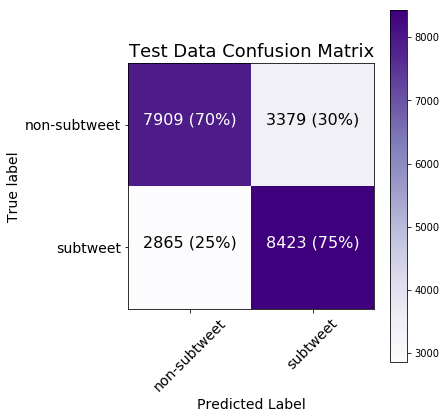

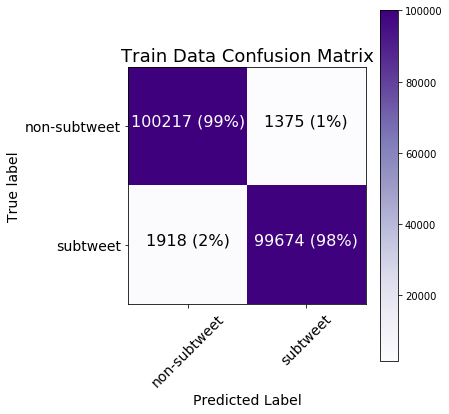

In [33]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [34]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [35]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [36]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➊")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(names_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [37]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [38]:
%%time
dataframes = process_tweets_for_testing(filenames)

CPU times: user 10.4 s, sys: 172 ms, total: 10.5 s
Wall time: 11.2 s


#### Show a random table

In [39]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
204,i don't understand why people feel the need to compare injustices to one another.....,2015-06-03 09:02:32,4,0,606083544469880832,0.9082
805,i want to complain about all the basic bitches at the ACT but i'm one of them,2013-02-09 08:57:04,4,0,300241911686520832,0.8809
774,Wait I can't tell if you're a bitch and pretending to be nice or a nice person who comes off as bitchy.,2013-03-07 13:10:22,1,0,309727741035548672,0.8690
379,These hoop earrings make me feel like a bad bitch. So bad I might listen to Taylor Swift. In ➊,2014-03-17 19:23:14,4,0,445701924621275137,0.8652
988,annoying peopLOUDER MUSIC,2012-11-06 12:22:42,1,0,265866813613670400,0.8564


#### Prepare statistics on tweets

In [40]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [41]:
test_df_stats = tests_df.describe()

In [42]:
test_df_stats.columns = ["User {}".format(i + 1) for i, column in enumerate(test_df_stats.columns)]

In [43]:
test_df_stats

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8,User 9,User 10,User 11,User 12,User 13,User 14
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.5177,0.5088,0.5590,0.5212,0.5282,0.4918,0.4289,0.5440,0.5160,0.4175,0.5457,0.5075,0.5532,0.5397
std,0.1153,0.1356,0.1219,0.1285,0.1082,0.1284,0.1148,0.1278,0.1248,0.1138,0.1242,0.1275,0.1262,0.1240
min,0.1248,0.0551,0.0945,0.0918,0.0604,0.0315,0.0166,0.1058,0.0270,0.0485,0.1032,0.0437,0.1247,0.0618
25%,0.4436,0.4158,0.4776,0.4300,0.4583,0.4118,0.3515,0.4640,0.4305,0.3515,0.4686,0.4238,0.4743,0.4688
50%,0.5183,0.5119,0.5567,0.5274,0.5268,0.4995,0.4310,0.5437,0.5204,0.4172,0.5457,0.5032,0.5539,0.5388
75%,0.5932,0.5999,0.6417,0.6128,0.5958,0.5742,0.5046,0.6312,0.5999,0.4938,0.6311,0.5929,0.6416,0.6224
max,0.8340,0.9624,0.9382,0.8885,0.9313,0.9082,0.8189,0.8884,0.9272,0.7216,0.8664,0.9508,0.8394,0.9178


#### Plot a histogram with three random users

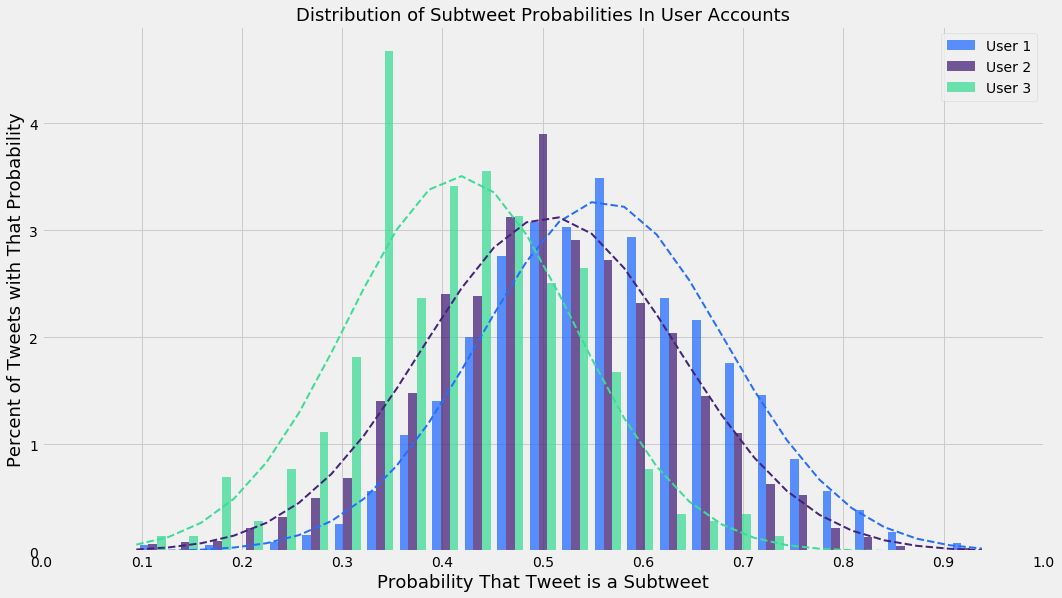

In [44]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]

line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [45]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [46]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5164
std,0.1269
min,0.0166
25%,0.4336
50%,0.5172
75%,0.6013
max,0.9624


#### Now plot

No handles with labels found to put in legend.


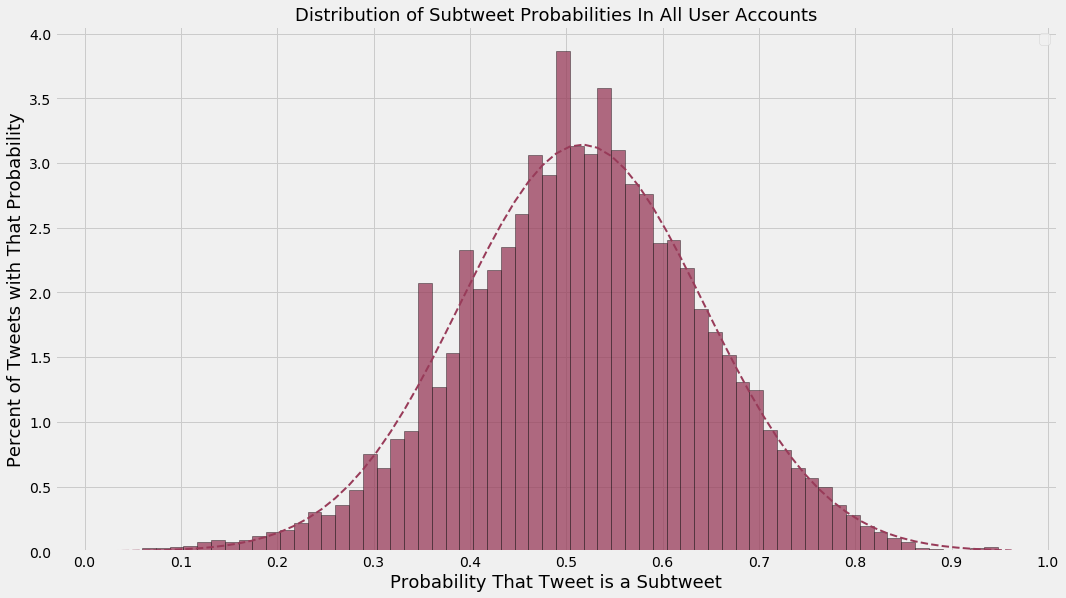

In [47]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [48]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")
                  .replace("➌", "")) for tweet in training_data]

#### Lengths

In [49]:
length_data = [len(tweet) for tweet in training_data]

In [50]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [51]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [52]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [53]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [54]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
19158,293,That's what gets me WHY low Brow him ?? Why By all that's right he should be impeachedhe is still involves himself in business foreignCabinet heads are just as slimy with using planes etc his disregard for bills Pres o put in 4 protecting us!!
17598,293,Again.. you worship a xenophobic God and a Bible that promotes hate as long as you don't ignore all those parts.. a God that sends people to burn in Hell forever for not believing in him....you don't get to call those talking with you haters!
21617,281,"It's my birthday weekend. Trying to max it out and max out my holiday before going back home. \n\nThat means moarrr hotsprings (went to a hotspring theme park). Soaked in water full of herbs, i feel pretty relaxed. And danced in the sauna. Gazed at the moon while soaking outdoors"
13366,281,"ARMY this is a serious issue and we are going address it including turning to the local police. We know it's not all of you, but a small group of haters. We need to make sure not to encourage that behavior, it against everything BTS, BigHit and ARMY stands for. Bully is not cool."
15612,281,"Meet Majibur Rahman of #Assam....In Darrang districts Sipajhar creating ""One Family One Village"". He is father of 20 children, eldest is 48 Yrs & youngest is just 3 yr old. His nearest competitor is his elder son having 10 Children. Now see how they r enjoying all Govt facilities"


#### Top 5 shortest tweets

In [55]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
10037,4,soft
9588,4,Fake
1718,4,Ugly
5554,4,Lame
19783,4,fear


#### Tweet length statistics

In [56]:
length_data_for_stats.describe()

,Length
count,22576.0000
mean,104.0671
std,73.4973
min,4.0000
25%,46.0000
50%,84.0000
75%,146.0000
max,293.0000


#### Punctuation

In [57]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [58]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [59]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
6400,13,"IF U WERE KILLED TOMORROW, I WOULDNT GO 2 UR FUNERAL CUZ ID B N JAIL 4 KILLIN DA PERSON THAT KILLED U!\n......__________________ \n...../_==o;;;;;;;;______[]\n.....), —-.(_(__) / \n....// (..) ), —--"" \n...//___// \n..//___// \nWE TRUE HOMIES WE RIDE TOGETHER WE DIE TOGETHER"
17741,11,"Going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting, deciding I would like to try them, then being told ""I'm sorry sir, that's actually not available...""\n\n[ then why the @#$% is it ON YOUR MENUUUUUUUU-- ]"
19322,11,(•_•)\n<) )\ I am no Wonder Woman\n / \\n\n\(•_•)\n ( (> I am not Supergirl\n / \\n\n\(-_•)/\n OO I am Power Girl!\n ) ( \n / \\n\n (•_•)\n <OO> #Bitchez \n ) (\n | |
21768,11,"[BanG Dream Girls Band Party Seiyuu Profiles Arpil 2018 Edition]\nOrder of Posting:\n- Hello, Happy World (4/8)\n- Roselia (4/8)\n- Pastel*Palettes (4/9)\n- Afterglow (4/9)\n- Poppin'Party (4/10)\n\nLet's go!"
20819,10,I created an equation to find the largest meaningful number in the observable universe.\n\nVolume Quantitative Infinity [vQ(inf)]= (4/3)(pi)ct^3\n\nI'll explain it in a thread. (1/?)


#### Tweets punctuation statistics

In [60]:
punctuation_data_for_stats.describe()

,Punctuation
count,22576.0000
mean,1.9845
std,1.6396
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


#### Stop words

In [61]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [62]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [63]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,tall scruffy men walking big fluffy dogs in manhattan >>>>>>>
12785,8,"I'm good & sleep in my room getting one of the best naps of my entire life then my mom comes in and goes hey take to Best Buy. I looked at her like she was crazy and she told me ""he needs it for school"" so I get my ass up and take him to Best Buy"
12759,8,why send me a code that I can't read? #Useless #FixIt
12760,8,"#Citrix Receiver auto-update is broken due to expired certificate < manually install certificate from article, or manually update to 4.12 when released"
12761,8,"Look, whatever else you want to say Stallone he wrote the best song ever to appear to over the opening credits to an unwatchable Saturday Night Live sequel and you'll never take that away from him"


#### Top 5 tweets with fewest stop words

In [64]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
13207,0,When
7104,0,Clever.
324,0,luv u
20624,0,When ?
4047,0,fuck


#### Tweets stop words statistics

In [65]:
stop_words_data_for_stats.describe()

,Stop words
count,22576.0000
mean,7.0955
std,1.3553
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [66]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [67]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [68]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [69]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [70]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
11365,"-Many👮‍♂️suffer in silence, not always by choice but by design! #PTSD can be a career killer & worse many PD's DO NOT see P.T.S.D as an insured disability; This has to change🆘- Hiding mine for 3 years made my #Fight unbearable!\n\nPlease help us #UnmaskPTSD & #SaveOurLives ⚖️",60
3409,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first.",59
21261,"Nat had a 104.5° fever so we took her to the doctor. He said she has fifth disease, and we posted about it on Facebook. This girl was like ""this is why my child isn't in daycare. Doctor said not to put mine in until she's 4."" Ok great that's YOUR baby's doctor. Not ours.🤷🏼‍♀️",59
14362,"GIVE AWAY!\n\nThe rules are really easy, all you have to do is :\n1. Must be following me (i check) \n2. RT and fav this tweet\n3. tag your mutuals/anyone\n4. only 1 winner! \n5. i ship worldwide;) \n\nit ends in 8th May 2018 or when this tweet hit 2k RT and like!\n\nGood luck! ❤",59
20115,"ur bday 21/8 u50. Fancy a kick about the park where we used to play.?Jumpers down- shots.Then 3 holes of golf.we hit any windows we run!What do u say- will be a laugh.I am 50 a week later.hey, we're still kind of fit:))give me a shout if up 4 it 07532203285 Liam",58


#### Top 5 tweets with fewest unique words

In [71]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
4047,fuck,1
7234,weak,1
10037,soft,1
16369,enjoy,1
10103,Bitch,1


#### Tweets unique words statistics

In [72]:
unique_words_data_for_stats.describe()

,Unique words
count,22576.0000
mean,18.8482
std,12.0551
min,1.0000
25%,9.0000
50%,16.0000
75%,26.0000
max,60.0000


#### Plot them

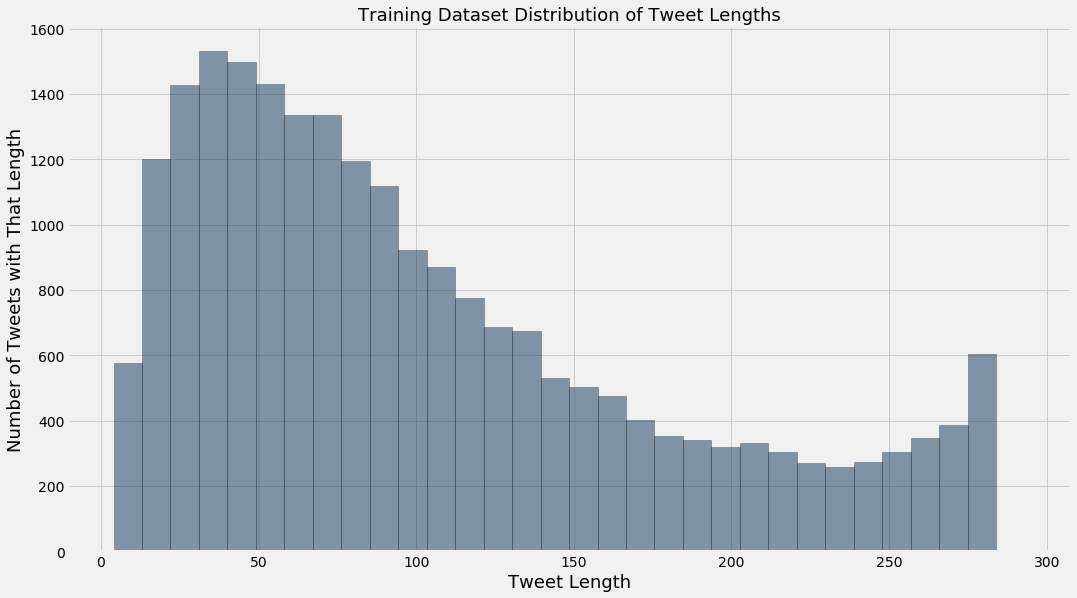

In [73]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

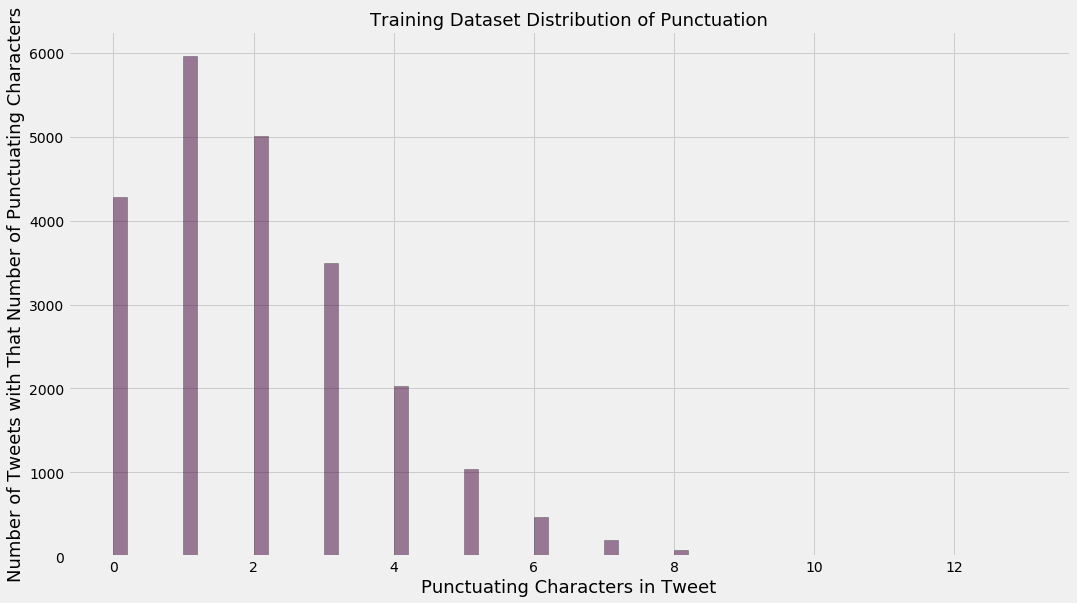

In [74]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

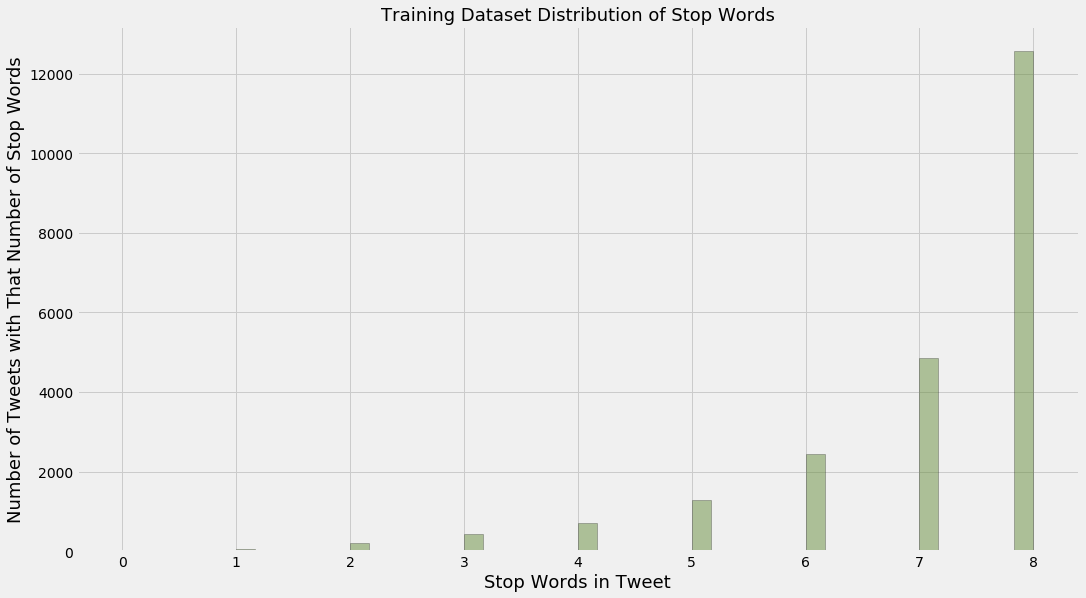

In [75]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

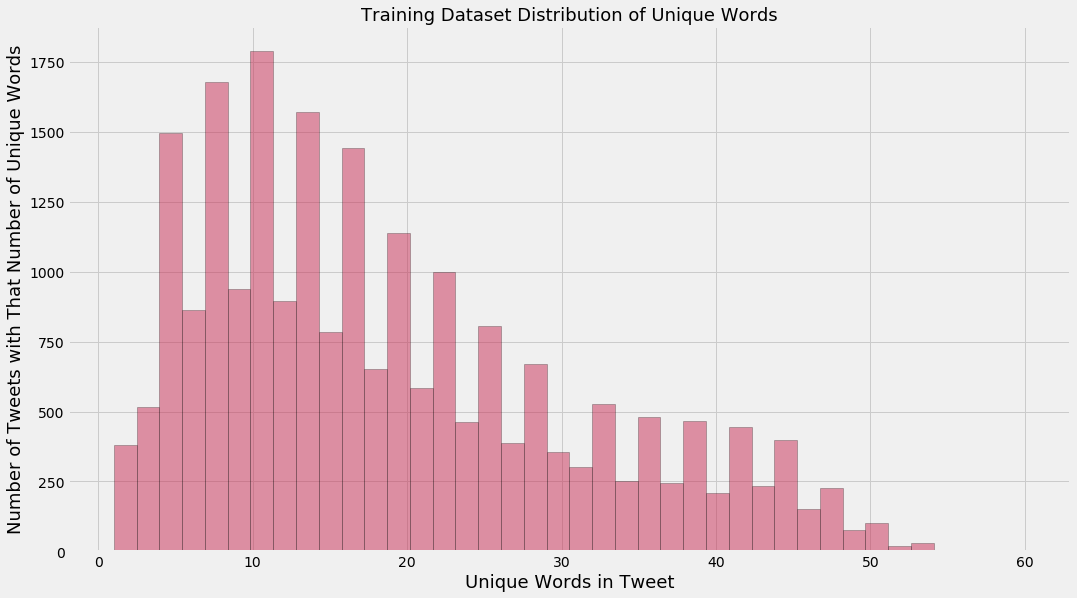

In [76]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()